# Source Sheet

A Source Sheet: an infinite row of sources along one line. Similar to a vortex sheet 

In [1]:
import numpy
import math
from matplotlib import pyplot

#embed the figures 
%matplotlib inline 

In [2]:
N= 100 
x_start, x_end = -1.0, 1.0 
y_start, y_end = -1.5, 1.5
x = numpy.linspace(x_start,x_end, N)
y = numpy.linspace(y_start, y_end, N)
X, Y = numpy.meshgrid(x,y)

In [16]:
# freestream speed 
u_inf = .0 

# calculate the velocity components due to the freestream 
u_freestream = u_inf*numpy.ones((N,N), dtype = 'float')
v_freestream = numpy.zeros((N,N), dtype ='float')

### Finite Number of Sources along a line 

We will first consider this case 

We will create classes again 

In [17]:
class Source: 
    """
    Contains information related to a source/sink 
    """
    def __init__(self, strength, x, y):
        """
        Sets the location and the strength of the singularity 
        
        Parameters
        -----------
        strength(float): strength of the source/sink
        x(float): x-coordinate of the source/sink 
        y(float): y-coordinate of the source/sink 
        """
        self.strength = strength 
        self.x, self.y = x, y
        
    def velocity(self, X, Y): 
        """
        Computes the velocity field generated by the source/sink 
        
        Parameters
        ----------
        X (2D Numpy array of floats): x-coordinates of the meshpoints 
        Y (2D Numpy array of floats): y-coordinates of the meshpoints
        """
        self.u = self.strength/(2*math.pi)*(X-self.x)/((X-self.x)**2+(Y-self.y)**2)
        self.v = self.strength/(2*math.pi)*(Y-self.y)/((X-self.x)**2+(Y-self.y)**2)
        
    def stream_function(self,X,Y): 
        """ 
        Computes the stream function generated by source/sink
        
        Parameters
        ----------
        X(2D Numpy array of floats): x-coordinates of the meshpoints 
        y(2D Numpy array of floats): y-coordinates of the meshpoint 
        """
        self.psi = self.strength/(2*math.pi)*numpy.arctan2((Y-self.y), (X-self.x))

We will use this code to to create as many sources that we want. We are going to pick N_source 

In [11]:
N_sources = 11 
strength = 5.0 
strength_source = strength/N_sources 
x_source = numpy.zeros(N_sources, dtype='float')
y_source = numpy.linspace(-1.0, 1.0, N_sources)

#create a source line (numpy array of source objects)
sources = numpy.empty(N_sources, dtype =object)
for i in range(N_sources):
    sources[i]= Source(strength_source, x_source[i], y_source[i]) 
    sources[i].velocity(X,Y)
    
#Super position of all sources to the free-stream flow 
u = u_freestream.copy()
v = v_freestream.copy()
for source in sources:
    u +=source.u
    v +=source.v 

In [18]:
N_sources = 11                                # number of sources
strength = 5.0                                # sum of all source strengths
strength_source = strength/N_sources          # strength of one source
x_source = numpy.zeros(N_sources, dtype=float)   # horizontal position of all sources (1D array)
y_source = numpy.linspace(-1.0, 1.0, N_sources)  # vertical position of all sources (1D array)

# create a source line (Numpy array of Source objects)
sources = numpy.empty(N_sources, dtype=object)
for i in range(N_sources):
    sources[i] = Source(strength_source, x_source[i], y_source[i])
    sources[i].velocity(X, Y)

# superposition of all sources to the free-stream flow
u = u_freestream.copy()
v = v_freestream.copy()
for source in sources:
    u += source.u
    v += source.v

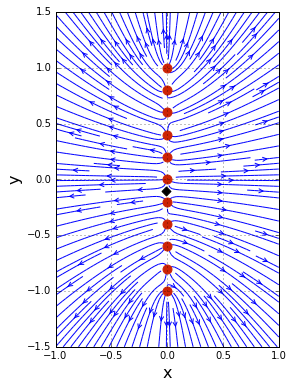

In [19]:
# plot the stream lines 
size = 4 
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid()
pyplot.xlabel('x', fontsize = 16)
pyplot.ylabel('y', fontsize = 16)
pyplot.streamplot(X,Y,u,v, density=2, linewidth=1, arrowsize=1, arrowstyle = '->')

# plot the sources 
pyplot.scatter(x_source, y_source, color = '#CD2305', s=80, marker='o')

# Compute the velocity magnitude and indices of the stagnation point 
# note: the stagnation pont is approximated with the smallest velocity magnitude 
magnitude = numpy.sqrt(u**2+v**2)
j_stagn, i_stagn = numpy.unravel_index(magnitude.argmin(), magnitude.shape)
# plot the stagnation points 
pyplot.scatter(x[i_stagn], y[j_stagn], color='black', s= 40, marker= 'D')
pyplot.xlim(x_start,x_end)
pyplot.ylim(y_start, y_end);